### Florian Muthreich   ---   INF368   ---

# Ex2: Locating Objects in Images: Object Detection

## Setup

I decided to tackle the task of Object Detection using Faster R-CNN as described by [Ren et al. 2015](https://arxiv.org/abs/1506.01497) [1]. An implementation of Faster R-CNN is available for Keras by [kbardool on GitHub](https://github.com/kbardool/keras-frcnn) [2], whose code I will use with some adjustments for this assignment.As a training set I created 1000 images using the Generator provided by [Ketil Malde](https://github.com/ketil-malde/image-simulator) [3]. This dataset comprises 4 classes of different fish, with about equal class balance. For training of the model, the data is split into a train and validation set at a ~80%/20% ratio. During the training the images are augmented with random horizontal or vertical flips and 90 degree rotation. 

### Architecture

The base CNN model uses the Resnet 50 architecture [He et al. 2015](https://arxiv.org/abs/1512.03385) [4]. The RPN and end-classifier follows the [Ren et al. 2015](https://arxiv.org/abs/1506.01497) [1] paper. A maximum of 300 boxes are proposed by the Region Proposal Network (RPN) per image with anchor box sizes of [128, 256, 512] and the ratios are [1:1, 1:2, 2:1]. 
The smallest side of the image is scaled to 600 pixels to save on computing time. 
The FRCNN model was trained for ~500 epochs from scratch, during training the lowest loss and best accuracy weights are saved in separate files. Within each epoch the RPN proposes regions 500 times. 

### File Structure

All code-files I used during this assignment can be found at [my GitHub](https://github.com/FM-uib/INF368/tree/master/Ex2) [5].
The model weights and images are stored on my instance 'instance-gpu-fmuth'.

In [ ]:
>
>|_Ex2/                             # Parent folder
>  |_ source_data/                  # Images used for the creation of the dataset
>  |_ keras_frcnn/                  # Code base for the Faster R-CNN based on [1] & [2]
>     |_ keras_frcnn                # sub funtions needed fro Code
>     |_ imgs/                      # folder with training/validation images
>     |_ timgs/                     # folder with 10 images
>     |_ results_imgs/              # folder with images of located and classified fish
>     |_ annotate.txt               # file with training images names bboxes and class identity
>     |_ test_frcnn                 # script to load weights and classify images in /timgs
>     |_ train_frcnn                # script to train Faster R-CNN network
>     |_ config.pickle              # config file with saved training runs settings
>     |_ model_frcnn.hdf5           # model weights with lowest loss 
>     |_ model_frcnn_best_acc.hdf5  # model weights with highest mean accuracy
>     |_ log.txt                    # log-file with loss and acc during training
>  |_ imagesim.py & generate.py     # from [3] used to generate the training images
>  |_ Assignment report.ipynb       # This File


### Results

We can see the training history in this first figure below. Loss decreases rapidly over the beginning epochs and approaches .5 by 500 Epochs, while mean accuracy approaches 95% of the validation set. 

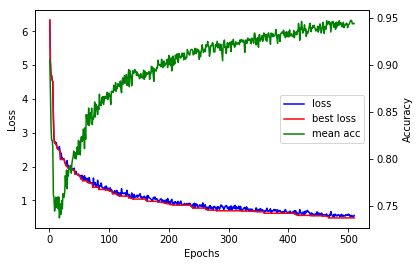

In [6]:
plot_curve()

I created some test images to see the performance of the model on new images it had not seen before. I used the image simulator [3] and created 10 new images and fed them into the network. The resulting bounding boxes and classification can be seen below in the images. 

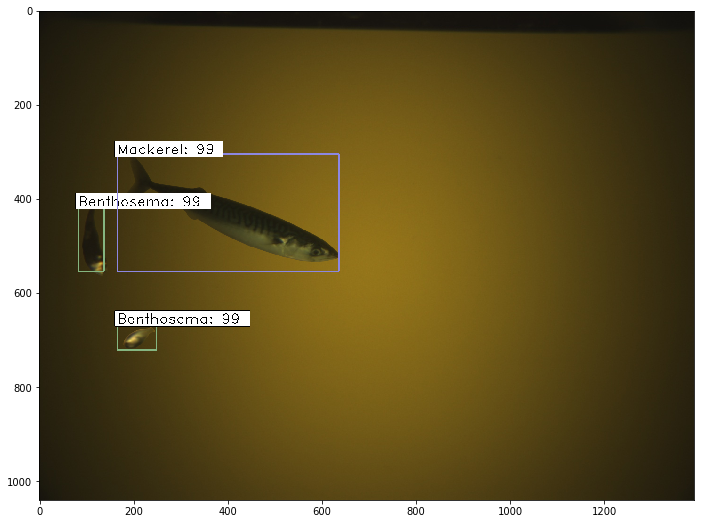

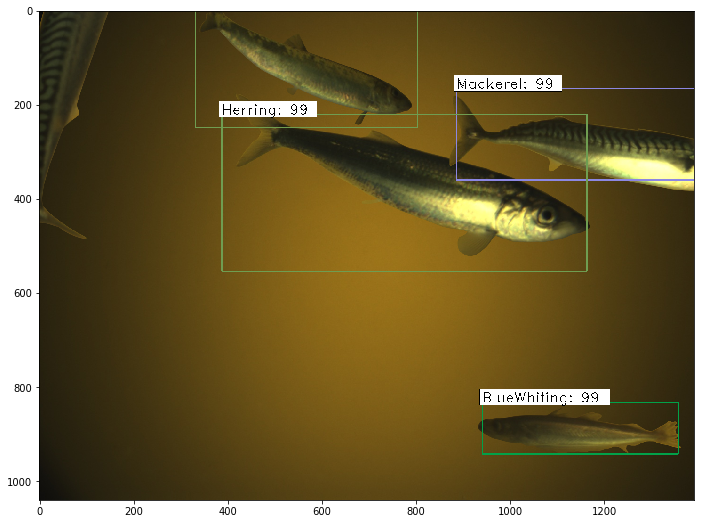

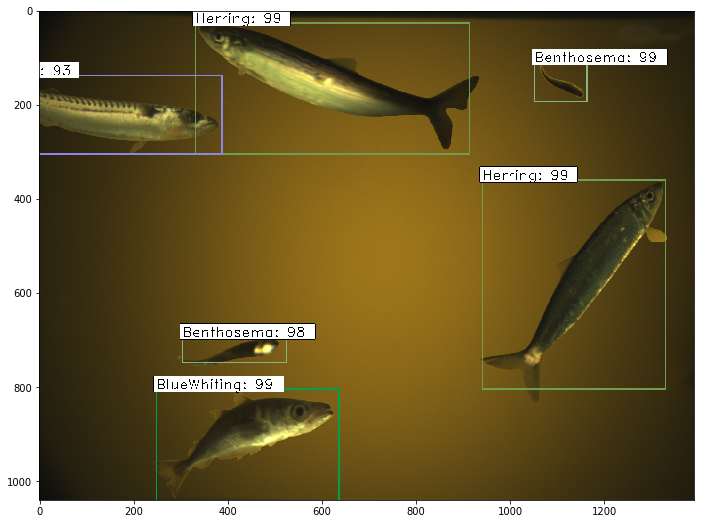

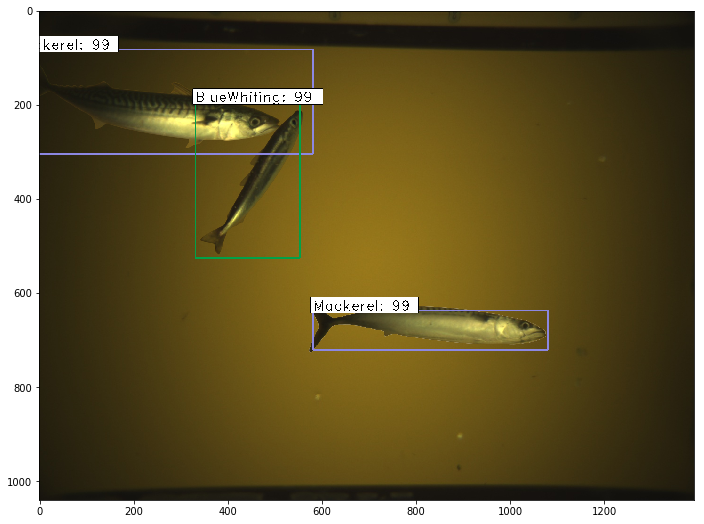

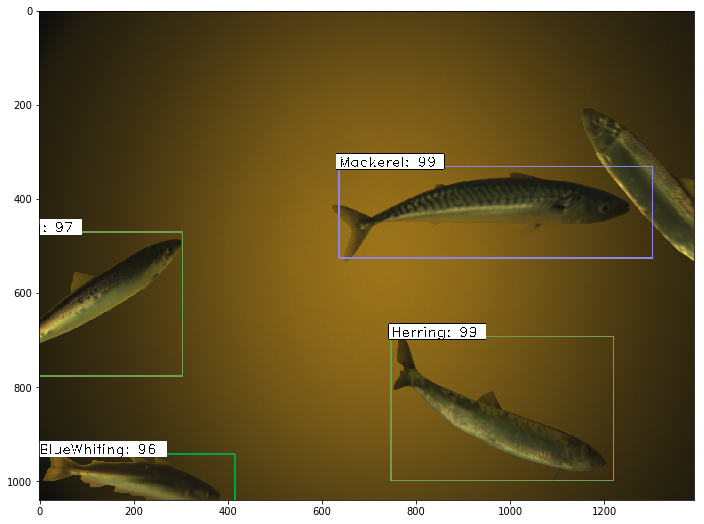

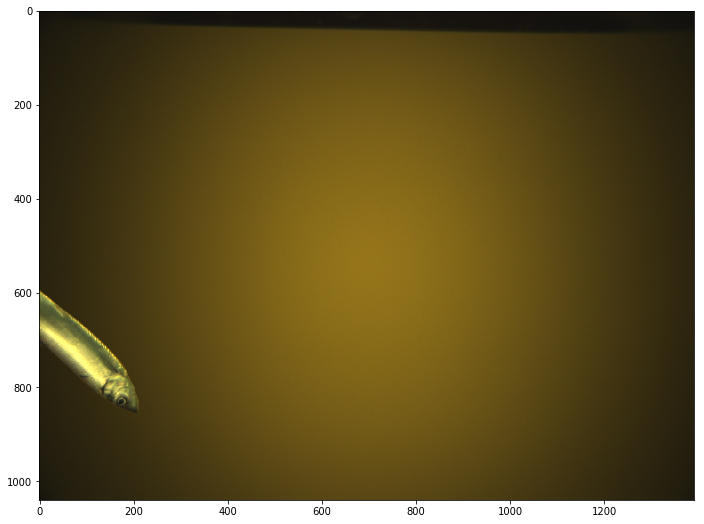

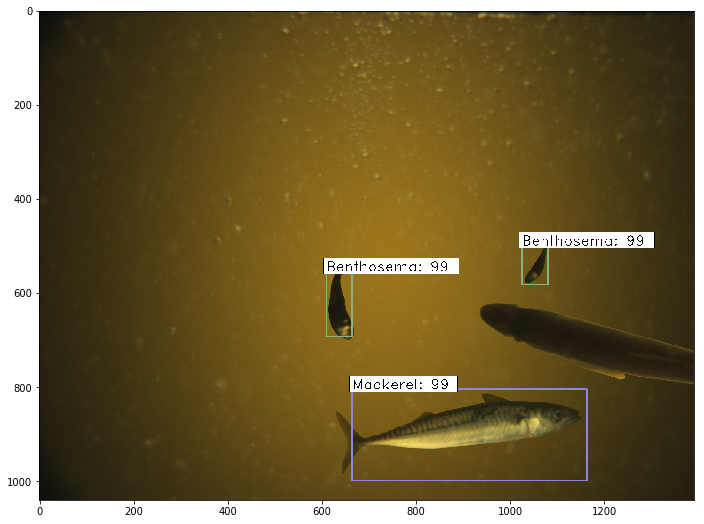

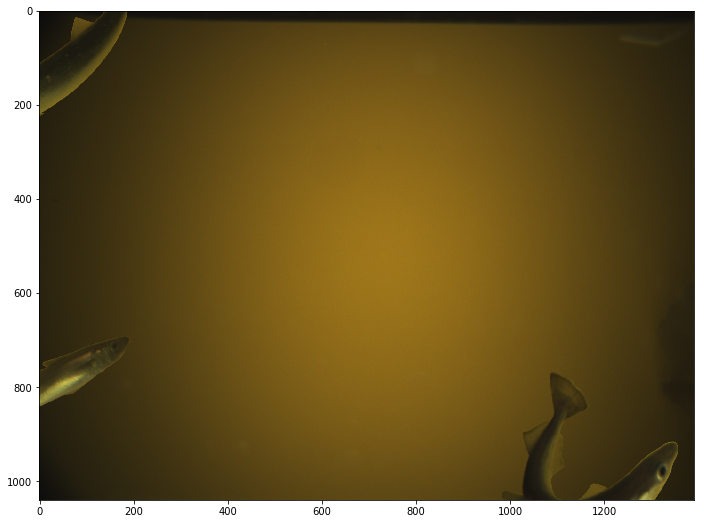

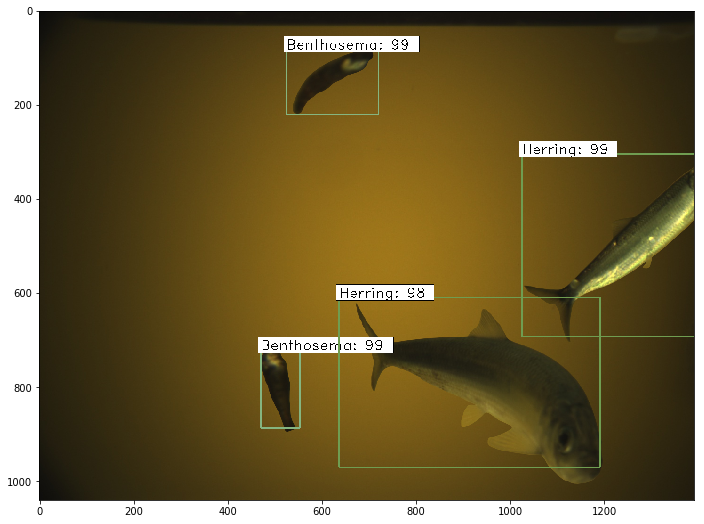

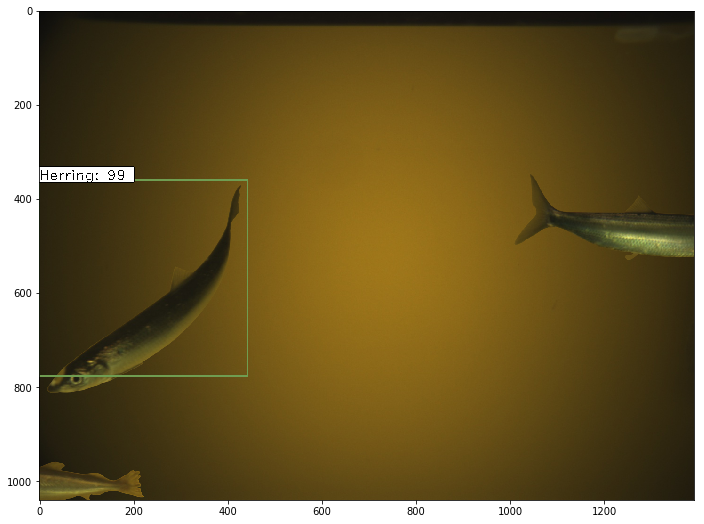

In [17]:
plot_imgs()

The network still struggles with partial fish at the edges of images, while most of the complete fish are correctly identified with very high confidence scores. Some bounding boxes are cutting of parts of the fish, but only minor small parts which could be improved by increasing the amount of regions that are proposed. 

### Improvements

Initially I wanted to build the entire coding base from scratch, but had to realize some way through the assignment that this would not be possible for me. I found the repository from [2] and chose to experiment with it. during inital testing I spent some time testing and understanding the code and experimented with refining trained weights, in the end I decided to train from scratch, because of the low number of classes. 
Another avenue I explored was a vastly increased training set and a TFrecords pipeline. Ultimately I was spending to much time on this endeavour after 5-6 days of no progress and decided to reduce the training set to 1000 images.
I would still like to improve the code of this approach and hopefully be able to implement TFrecords at some point.

### References

[1] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. 2015. "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks"

[2] kbardool Keras-FRCNN: https://github.com/kbardool/keras-frcnn

[3] Ketil Malde Image Simulator: https://github.com/ketil-malde/image-simulator

[4] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. 2015. Deep Residual Learning for Image Recognition 
https://arxiv.org/abs/1512.03385

[5] Github Repository : https://github.com/FM-uib/INF368/tree/master/Ex2

In [5]:
def plot_curve():
    import pandas as pd
    import matplotlib.pyplot as plt
    d = pd.read_csv("keras-frcnn/log.txt", delimiter="\t", header = 0)

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    lns1 = ax1.plot(range(1, 511), d["curr_loss"], color="blue", label = "loss")
    lns2 = ax1.plot(range(1, 511), d["best_loss"], color="red", label = "best loss")
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()

    ax2.set_ylabel('Accuracy')
    lns3 = ax2.plot(range(1, 511), d["mean_acc"], color = "green", label = "mean acc")
    ax2.tick_params(axis='y')

    lns = lns1+lns2+lns3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")

    plt.show()

Some Code to stitch the separate txt files with objects/bboxes together into on file (annotate.txt)

In [18]:
import pandas as pd
import glob
import numpy as np

def read_txt(path):
    frame = pd.read_csv(path, sep = "\t", header = None , names = ["x1","y1","x2","y2","class_name"])
    fnames = pd.DataFrame({"file_name" : np.repeat(re.sub(r"keras-frcnn/","",re.sub(r".txt", ".png", path)), len(frame))})
    final = pd.concat([fnames, frame], axis = 1)
    return final

files = glob.glob("*/imgs/*.txt")
files2 = [read_txt(i) for i in files]
files2 = pd.concat(files2)
files2.to_csv('keras-frcnn/annotate.txt', header=None, index=None, sep=',')

Index(['curr_loss', ' best_loss', ' mean_acc '], dtype='object')

In [16]:
def plot_imgs():
    import glob
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    files = glob.glob("*/results_imgs/*.png")
    for i in files:
        img=mpimg.imread(i)
        imgplot = plt.imshow(img)
        plt.rcParams["figure.figsize"] = [20,9]
        plt.show()